# Stock Price Prediction with PCA+LSTM 

## This Project is mainly about using PCA and LSTM to predict the stock price.
## This notebook is Part I
### Done by Wes, Hans, Charlie 
### NYU Tandon


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import LSTM_techinal_indicators as ta
%matplotlib inline

## Here we use AAPL to conduct our research.
## We first show how we construct the most simple model, named modelA, which only uses the trading data with LSTM to predict the stock price of AAPL.

In [2]:
## read  data
aapl_data = pd.read_csv(r"./AAPL.csv")
aapl_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,3.745536,4.017857,3.631696,3.997768,3.478462,133949200
1,2000-01-04,3.866071,3.950893,3.613839,3.660714,3.185191,128094400
2,2000-01-05,3.705357,3.948661,3.678571,3.714286,3.231803,194580400
3,2000-01-06,3.790179,3.821429,3.392857,3.392857,2.952128,191993200
4,2000-01-07,3.446429,3.607143,3.410714,3.553571,3.091966,115183600


## Set Param for model A:
### Input model A merely involves basic trading data, which are HLOC+Volume,  not data will need PCA adjustment

In [3]:
## Set the test period
Test_period = 100
## Set the length of the input sequence
window = 30
## Wether generate Technical indicator
Tech_indicator = False
## Wether use PCA or not
PCA_use = False
## Whether ONLY PCA transform the Technical indicator
PCA_only_indicator = False 

### Calculate technical Indicators (NOT needed now, but used later on, just display here.)

In [4]:
def CalTechIndicator(data_set):
    data_set = ta.accumulation_distribution(data_set,2)
    data_set = ta.macd(data_set,12,26)
    data_set = ta.chaikin_oscillator(data_set)
    data_set = ta.Highest(data_set)
    data_set = ta.Lowest(data_set)
    data_set = ta.stochastic_oscillator_k(data_set)
    data_set = ta.stochastic_oscillator_d(data_set,3)
    data_set = ta.Walliam(data_set)
    data_set = ta.RSI(data_set,n=1)
    data_set = ta.AC(data_set,n=1)
    data_set = ta.PROC(data_set,n=10)
    data_set = ta.VROC(data_set,n=10)
    data_set = ta.on_balance_volume(data_set,n=1)
    data_set = ta.ultimate_oscillator(data_set)
    data_set = ta.money_flow_index(data_set,n=1)
    data_set = data_set.drop('RSI_1',axis=1)  ## There is nan within this features
    data_set = data_set.drop('Acc/Dist_ROC_2',axis=1)  ## There is nan within this features
    data_set = data_set.dropna()
    return data_set
tec_data = CalTechIndicator(aapl_data)
tec_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MACD_12_26,Chaikin,Highest,Lowest,SO%k,SO%d_3,W-R%,Acceleration_1,Price Rate of Change,Volume Rate of Change,OBV_1,Ultimate_Osc,MFI_1
27,2000-02-10,4.031250,4.066964,3.928571,4.053571,3.527016,75745600,0.072692,1.061973e+07,4.102679,3.455357,0.903225,0.654447,0.096775,0.031250,0.031818,-0.109253,75745600.0,4.282497,0.0
28,2000-02-11,4.058036,4.075893,3.866071,3.883929,3.379410,53062800,0.066038,-1.421005e+07,4.102679,3.529018,0.085110,0.369779,0.914890,-0.169642,0.070111,-0.498638,-53062800.0,4.096330,0.0
29,2000-02-14,3.904018,4.138393,3.879464,4.136161,3.598878,91884800,0.078397,1.961199e+07,4.136161,3.529018,0.991380,0.680579,0.008620,0.252232,0.116265,-0.476201,91884800.0,4.264500,1.0
30,2000-02-15,4.116071,4.283482,4.113839,4.250000,3.697929,121436000,0.095467,2.631981e+07,4.250000,3.529018,0.802633,0.741606,0.197367,0.113839,0.187032,0.527328,121436000.0,4.399789,1.0
31,2000-02-16,4.205357,4.218750,4.004464,4.075893,3.546439,94561600,0.094884,-6.716711e+06,4.250000,3.529018,0.333335,0.537470,0.666665,-0.174107,0.154965,-0.185157,-94561600.0,3.849765,0.0


In [5]:
## Save Original Data Here
aapl_data = aapl_data.drop(['Date'],axis=1) ##Delete the Date Column
ori_aapl_data = aapl_data.copy()
aapl_data.head()

,Open,High,Low,Close,Adj Close,Volume
0,3.745536,4.017857,3.631696,3.997768,3.478462,133949200
1,3.866071,3.950893,3.613839,3.660714,3.185191,128094400
2,3.705357,3.948661,3.678571,3.714286,3.231803,194580400
3,3.790179,3.821429,3.392857,3.392857,2.952128,191993200
4,3.446429,3.607143,3.410714,3.553571,3.091966,115183600


## Applying PCA (NOT needed now, but used later on.)

In [6]:
if  PCA_use:
    from sklearn.decomposition import PCA
    pca = PCA(n_components=10)
    ## Apply PCA only to tech_indicator
    if PCA_only_indicator: 
        HLOCAV = ori_aapl_data.iloc[:,:5]
        ## reset the index to match tech_indicator
        HLOCAV.index=list(range(len(ori_aapl_data)))
        tech_factor = ori_aapl_data.iloc[:,6:]
        tech_pca = pd.DataFrame(pca.fit_transform(tech_factor))
        aapl_data =pd.concat([HLOCAV,tech_pca],axis=1)
    ## Apply PCA to all the features
    else:
        aapl_data = pd.DataFrame(pca.fit_transform(aapl_data))

## Data processing

In [7]:
## Using Adj close as target; Using all data as features
train_total = aapl_data.iloc[:-Test_period]
X_test = aapl_data.iloc[-Test_period:]
Y_test = ori_aapl_data.iloc[-Test_period:,4] ## The forth column is the adj-close, which is the target

In [8]:
## Min Max Normalization-----training set
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
sc1 = MinMaxScaler(feature_range = (0, 1))
aapl_data_scaled = sc.fit_transform(train_total)
target_scaled = sc1.fit_transform(np.array(aapl_data.iloc[:-Test_period,4]).reshape(-1,1))
target_scaled_mean = target_scaled.mean()
## zero_mean
col = aapl_data_scaled.shape[0]
mean_array = np.mean(aapl_data_scaled, axis=0)
mean_matrix = np.tile(mean_array, (col,1))
aapl_data_scaled -= mean_matrix
target_scaled -= target_scaled.mean()

In [9]:
## Split training features and target
X_train_n = aapl_data_scaled.copy()
Y_train_n = target_scaled
X_train = []
y_train = []
for i in range(window, len(X_train_n)):
    X_train.append(X_train_n[i-window:i, :])
    y_train.append(Y_train_n[i, ])  
X_train, y_train = np.array(X_train), np.array(y_train)
feature_nums = aapl_data.shape[1]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], feature_nums))

## LSTM model 

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

D:\Coding\Anaconda\Lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
regressor = Sequential()
## input matrices intialization method Glorot Uniform
regressor.add(LSTM(units = 50, return_sequences = True,kernel_initializer="glorot_normal",input_shape = (X_train.shape[1], feature_nums)))
regressor.add(Dropout(0.2))
## recurrent matrices intialization method Orthogonal 
regressor.add(LSTM(units = 50,kernel_initializer="Orthogonal"))
regressor.add(Dropout(0.2))

# regressor.add(LSTM(units = 50, return_sequences = True,kernel_initializer="Orthogonal"))
# regressor.add(Dropout(0.2))

# regressor.add(LSTM(units = 50,kernel_initializer="Orthogonal"))
# regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 50)            11400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 31,651
Trainable params: 31,651
Non-trainable params: 0
_________________________________________________________________


In [12]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
4882/4882 [==============================] - 6s 1ms/step - loss: 0.0023
Epoch 2/10
4882/4882 [==============================] - 5s 983us/step - loss: 8.4758e-04
Epoch 3/10
4882/4882 [==============================] - 5s 961us/step - loss: 7.7853e-04
Epoch 4/10
4882/4882 [==============================] - 5s 953us/step - loss: 7.7748e-04
Epoch 5/10
4882/4882 [==============================] - 5s 958us/step - loss: 6.7770e-04
Epoch 6/10
4882/4882 [==============================] - 5s 959us/step - loss: 6.4930e-04
Epoch 7/10
4882/4882 [==============================] - 5s 973us/step - loss: 6.4974e-04
Epoch 8/10
4882/4882 [==============================] - 5s 976us/step - loss: 6.4353e-04
Epoch 9/10
4882/4882 [==============================] - 5s 969us/step - loss: 6.0927e-04
Epoch 10/10
4882/4882 [==============================] - 5s 965us/step - loss: 6.3724e-04


## Test and Plot the Result

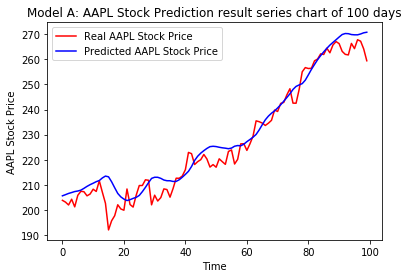

In [13]:
### Test Data
dataset_total = np.concatenate((train_total,X_test),axis=0)
inputs = dataset_total[len(dataset_total) - len(X_test) - window:]

## transform the test data
inputs = sc.transform(inputs)
test_col = inputs.shape[0]
mean_matrix2 = np.tile(mean_array, (test_col,1))
inputs -= mean_matrix2

X_test_set = []
for i in range(window, len(inputs)):
    X_test_set.append(inputs[i-window:i, :])
X_test_set = np.array(X_test_set)
X_test_set = np.reshape(X_test_set, (X_test_set.shape[0], X_test_set.shape[1], feature_nums))
predicted_stock_price = regressor.predict(X_test_set)

## re-transform the predicted value
predicted_stock_price += target_scaled_mean
predicted_stock_price = sc1.inverse_transform(predicted_stock_price)

## real price
real_stock_price = np.array(Y_test)

# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real AAPL Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted AAPL Stock Price')
plt.title('Model A: AAPL Stock Prediction result series chart of '+str(Test_period)+' days')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price')
plt.legend()
plt.show()

## Then we make encapsulation of the code, in order to conduct our research in a more convenient way.

# Encapsulation
## For furthur research in different models and settings

In [14]:
## read  data
aapl_data = pd.read_csv(r"./AAPL.csv")

In [15]:
def LSTM_Predict_Model(data, Period, Win, Tec, Pca, Pca_indicator):
    """
    This function is for encapsulation, mainly for furthur research and avoid repeating process. 
    Params:
    data:   DataFrame, the stock data downlownded from Yahoo Finance.
    Period: Int, the testing period.
    Win:    Int, the training Window. 
    Tec:    Bool, whether calculate Technical indicator.
    Pca and Pca_indicator: Bools, wether use PCA and whether only apply it for Tec_indicator.
    """
    ## Tec_indicator
    if Tec:
        print("Tech_indicator is generated.")
        data = CalTechIndicator(data)
    data = data.drop(['Date'],axis=1) ##Delete the Date Column
    ori_data = data.copy()
    ## PCA
    if  Pca:
        from sklearn.decomposition import PCA
        pca = PCA(n_components=10)
        ## Apply PCA only to tech_indicator
        if Pca_indicator: 
            HLOCAV = ori_data.iloc[:,:5]
            ## reset the index to match tech_indicator
            HLOCAV.index=list(range(len(ori_data)))
            tech_factor = ori_data.iloc[:,6:]
            tech_pca = pd.DataFrame(pca.fit_transform(tech_factor))
            data = pd.concat([HLOCAV,tech_pca],axis=1)
        ## Apply PCA to all the features
        if Pca_indicator == False:
            data = pd.DataFrame(pca.fit_transform(data))
    
    ## Data processing
    train_total = data.iloc[:-Period]
    X_test = data.iloc[-Period:]
    
    Y_test = ori_data.iloc[-Period:,4] ## The forth column is the adj-close, which is the target
    
    ## Min Max Normalization-----training set
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range = (0, 1))
    sc1 = MinMaxScaler(feature_range = (0, 1))
    data_scaled = sc.fit_transform(train_total)
    target_scaled = sc1.fit_transform(np.array(ori_data.iloc[:-Period,4]).reshape(-1,1))
    target_scaled_mean = target_scaled.mean()
    ## zero_mean
    col = data_scaled.shape[0]
    mean_array = np.mean(data_scaled, axis=0)
    mean_matrix = np.tile(mean_array, (col,1))
    data_scaled -= mean_matrix
    target_scaled -= target_scaled_mean
    ## Split training featfures and target
    X_train_n = data_scaled.copy()
    Y_train_n = target_scaled
    X_train = []
    y_train = []
    for i in range(Win, len(X_train_n)):
        X_train.append(X_train_n[i-Win:i, :])
        y_train.append(Y_train_n[i, ])  
    X_train, y_train = np.array(X_train), np.array(y_train)
    feature_nums = data.shape[1]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], feature_nums))
    ## LSTM model
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM
    from keras.layers import Dropout
    
    regressor = Sequential()
    ## input matrices intialization method Glorot Uniform
    regressor.add(LSTM(units = 50, return_sequences = True,kernel_initializer="glorot_normal",input_shape = (X_train.shape[1], feature_nums)))
    regressor.add(Dropout(0.2))
    ## recurrent matrices intialization method Orthogonal 
    regressor.add(LSTM(units = 50,kernel_initializer="Orthogonal"))
    regressor.add(Dropout(0.2))
    # regressor.add(LSTM(units = 50, return_sequences = True,kernel_initializer="Orthogonal"))
    # regressor.add(Dropout(0.2))
    # regressor.add(LSTM(units = 50,kernel_initializer="Orthogonal"))
    # regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 1))
    print("For Test Period = "+str(Period))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['mae','mape'])
    regressor.fit(X_train, y_train, epochs = 10, batch_size = 32)
    ### Test Data
    dataset_total = np.concatenate((train_total,X_test),axis=0)
    inputs = dataset_total[len(dataset_total) - len(X_test) - Win:]
    ## transform the test data
    inputs = sc.transform(inputs)
    test_col = inputs.shape[0]
    mean_matrix2 = np.tile(mean_array, (test_col,1))
    inputs -= mean_matrix2
       
    X_test_set = []
    for i in range(Win, len(inputs)):
        X_test_set.append(inputs[i-Win:i, :])
    X_test_set = np.array(X_test_set)
    X_test_set = np.reshape(X_test_set, (X_test_set.shape[0], X_test_set.shape[1], feature_nums))
    
    ## Get the transformed Y_test to Evaluate the Model
    Y_test_scaled=sc1.transform(np.array(Y_test).reshape(-1,1))
    Y_test_scaled =Y_test_scaled - target_scaled_mean
    
    ## Evaluate the Model
    evaluation = regressor.evaluate(X_test_set,Y_test_scaled,batch_size=32)

    print("\n-----Model Evaluation Result of "+str(Period)+" Days Testing Period-----\n")
    print("Loss value:",evaluation[0])
    print("MAE:",evaluation[1])
    print("MAPE:",evaluation[2])
    print("\n")
    
    
    ##Get the predicted result
    predicted_stock_price = regressor.predict(X_test_set)
    ## re-transform the predicted value
    predicted_stock_price += target_scaled_mean
    predicted_stock_price = sc1.inverse_transform(predicted_stock_price)
    ## real price
    real_stock_price = np.array(Y_test)
    return [[real_stock_price,predicted_stock_price],evaluation]

def Visulization(Modelresult,Test_period,Model_name):
    """
    This function is for result and Evaluation Result visulization in a 3*1 dim.
    Params:
    Modelresult:  list. The result from each model.
    Test_period:  list. The test period list.
    Model_neam:   string. The Model label. i.e.A,B,C,D.
    """
    import seaborn as sns
    c1, c2, c3,c4,c5 = sns.color_palette("pastel", 5)
    # Visualising the results
    fig = plt.figure(figsize=[12,24])
    ax1 = fig.add_subplot(411)
    ax1.plot(Modelresult[0][0][0], color = c1, label = 'Real AAPL Stock Price')
    ax1.plot(Modelresult[0][0][1], color = c2, label = 'Predicted AAPL Stock Price')
    ax1.set_title('Model '+Model_name+': AAPL Stock Prediction result series chart of '+str(Test_period[0])+' days')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('AAPL Stock Price')
    ax1.legend()
    
    ax2 = fig.add_subplot(412)
    ax2.plot(Modelresult[1][0][0], color = c1, label = 'Real AAPL Stock Price')
    ax2.plot(Modelresult[1][0][1], color = c2, label = 'Predicted AAPL Stock Price')
    ax2.set_title('Model '+Model_name+': AAPL Stock Prediction result series chart of '+str(Test_period[1])+' days')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('AAPL Stock Price')
    ax2.legend()

    ax3 = fig.add_subplot(413)
    ax3.plot(Modelresult[2][0][0], color = c1, label = 'Real AAPL Stock Price')
    ax3.plot(Modelresult[2][0][1], color = c2, label = 'Predicted AAPL Stock Price')
    ax3.set_title('Model '+Model_name+': AAPL Stock Prediction result series chart of '+str(Test_period[2])+' days')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('AAPL Stock Price')
    ax3.legend()
    
    ax4 = fig.add_subplot(427)
    
    MAE=[Modelresult[0][1][1],Modelresult[1][1][1],Modelresult[2][1][1]]
    
    
    ax4.bar(["100","200","400"],MAE, color=c3, width=0.8,label = 'Mean Absolute Error')
    ax4.set_title('Bar Graph of Mean Absolute Error')
    ax4.set_xlabel('Test Period')
    ax4.set_ylabel('Mean Absolute Error')
    ax4.legend()
    
    ax5 = fig.add_subplot(428)
    
    MAPE=[Modelresult[0][1][2],Modelresult[1][1][2],Modelresult[2][1][2]]
    
    ax5.bar(["100","200","400"],MAPE, color=c4, width=0.8,label = 'Mean Absolute Percentage Error')
    ax5.set_title('Mean Absolute Percentage Error')
    ax5.set_xlabel('Test Period')
    ax5.set_ylabel('Bar Graph of Mean Absolute Percentage Error')
    ax5.legend()
    plt.show()

## ModelA: Result
### Recall that, Input in model A merely involves basic trading data, which are HLOC+Volume,  not data will need PCA adjustment

For Test Period = 100
Epoch 1/10
4882/4882 [==============================] - 5s 1ms/step - loss: 0.0022 - mae: 0.0276 - mape: 24.2746
Epoch 2/10
4882/4882 [==============================] - 5s 967us/step - loss: 8.1495e-04 - mae: 0.0193 - mape: 16.2316
Epoch 3/10
4882/4882 [==============================] - 5s 976us/step - loss: 7.8945e-04 - mae: 0.0190 - mape: 16.0473
Epoch 4/10
4882/4882 [==============================] - 5s 1ms/step - loss: 7.2359e-04 - mae: 0.0180 - mape: 14.9772A: 2s - loss: 7.4
Epoch 5/10
4882/4882 [==============================] - 5s 999us/step - loss: 7.8610e-04 - mae: 0.0188 - mape: 15.5419
Epoch 6/10
4882/4882 [==============================] - 5s 984us/step - loss: 6.8186e-04 - mae: 0.0179 - mape: 14.6470
Epoch 7/10
4882/4882 [==============================] - 5s 999us/step - loss: 6.0387e-04 - mae: 0.0170 - mape: 13.9028
Epoch 8/10
4882/4882 [==============================] - 5s 986us/step - loss: 6.5167e-04 - mae: 0.0175 - mape: 15.0178
Epoch 9/10
4882/4

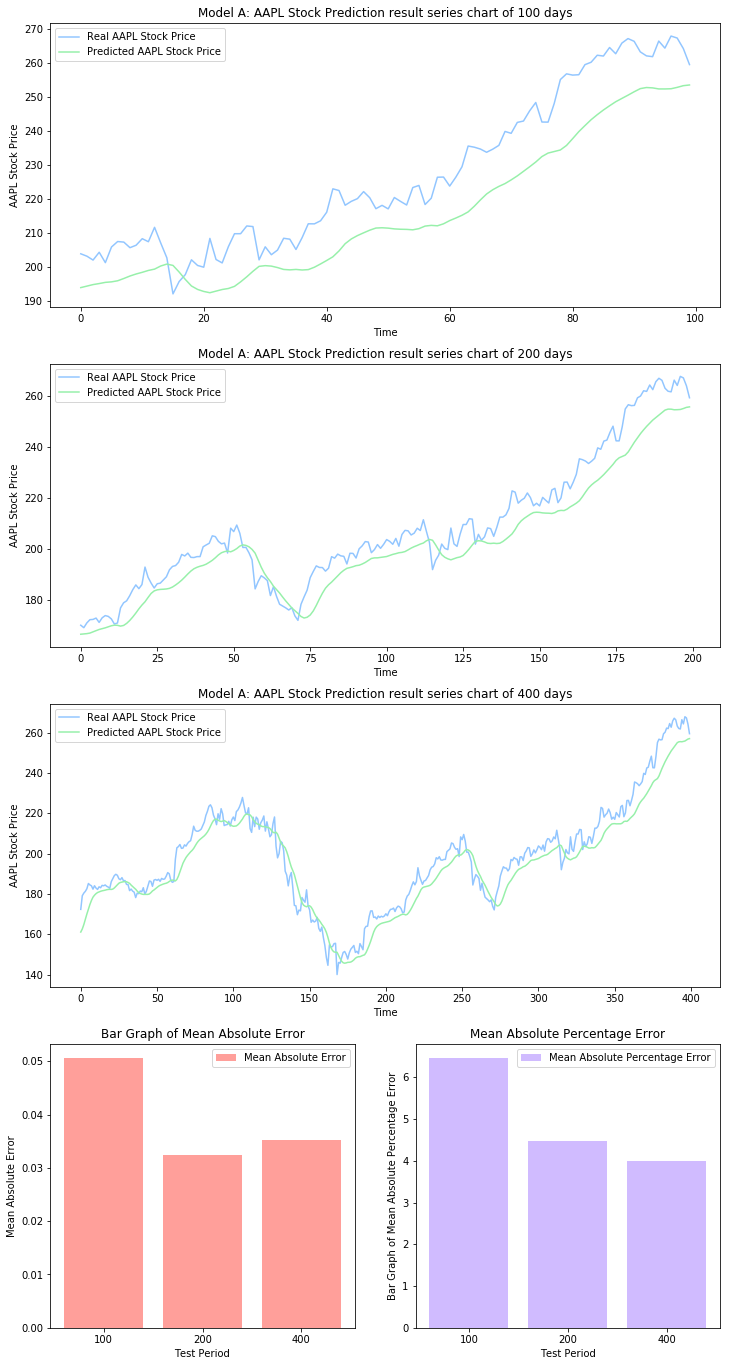

In [16]:
## Set the test period
Test_period = [100, 200, 400]
## Set the length of the input sequence
window = 30
## Wether generate Technical indicator
Tech_indicator = False
## Wether use PCA or not
PCA_use = False
## Whether ONLY PCA transform the Technical indicator
PCA_only_indicator = False 
ModelA =[]
for Peri in Test_period:
    A = LSTM_Predict_Model(aapl_data, Peri, 30, Tech_indicator, PCA_use, PCA_only_indicator)
    ModelA.append(A)
Visulization(ModelA,Test_period,'A')

## Model B:
### Input in model B  involves basic trading data with calculated tech_indicator, not data will need PCA adjustment

Tech_indicator is generated.
For Test Period = 100
Epoch 1/10
4855/4855 [==============================] - 6s 1ms/step - loss: 0.0022 - mae: 0.0291 - mape: 21.2516A:
Epoch 2/10
4855/4855 [==============================] - 5s 990us/step - loss: 7.7416e-04 - mae: 0.0193 - mape: 14.9757
Epoch 3/10
4855/4855 [==============================] - 5s 986us/step - loss: 7.7420e-04 - mae: 0.0192 - mape: 14.4929
Epoch 4/10
4855/4855 [==============================] - 5s 986us/step - loss: 6.5464e-04 - mae: 0.0177 - mape: 13.2686
Epoch 5/10
4855/4855 [==============================] - 5s 987us/step - loss: 6.1678e-04 - mae: 0.0172 - mape: 12.7717
Epoch 6/10
4855/4855 [==============================] - 5s 989us/step - loss: 6.5281e-04 - mae: 0.0178 - mape: 13.2281
Epoch 7/10
4855/4855 [==============================] - 5s 990us/step - loss: 6.1228e-04 - mae: 0.0174 - mape: 13.0326
Epoch 8/10
4855/4855 [==============================] - 5s 999us/step - loss: 5.2950e-04 - mae: 0.0160 - mape: 11.8577
E

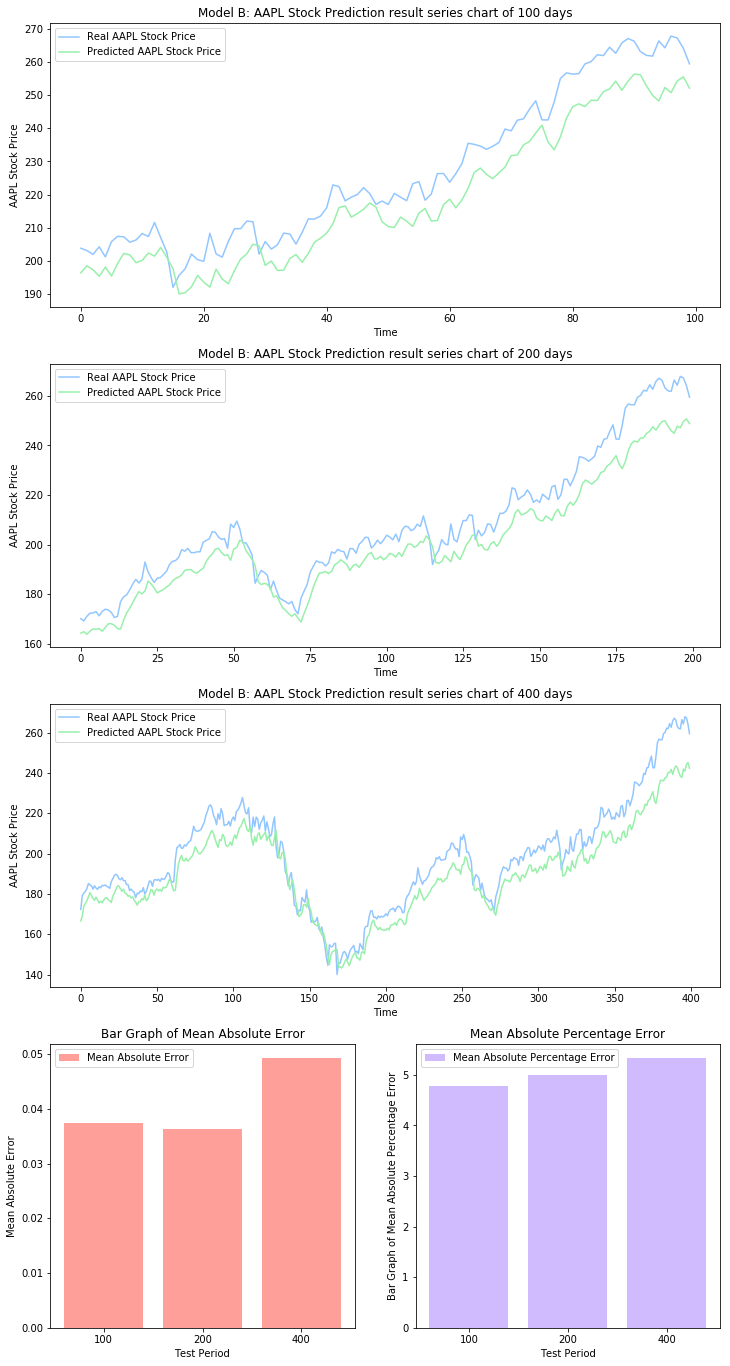

In [17]:
Test_period = [100, 200, 400]
ModelB =[]
for Peri in Test_period:
    B = LSTM_Predict_Model(aapl_data, Peri, Win=30, Tec=True, Pca=False, Pca_indicator=False)
    ModelB.append(B)
Visulization(ModelB,Test_period,'B')

## Model C:
### Input in model C involves basic trading data with calculated tech_indicator, all features will need PCA adjustment

Tech_indicator is generated.
For Test Period = 100
Epoch 1/10
4855/4855 [==============================] - 6s 1ms/step - loss: 0.0056 - mae: 0.0427 - mape: 32.8555
Epoch 2/10
4855/4855 [==============================] - 5s 1ms/step - loss: 8.0054e-04 - mae: 0.0197 - mape: 15.4896
Epoch 3/10
4855/4855 [==============================] - 5s 1ms/step - loss: 7.2715e-04 - mae: 0.0185 - mape: 14.2746
Epoch 4/10
4855/4855 [==============================] - 5s 1ms/step - loss: 6.7160e-04 - mae: 0.0178 - mape: 13.6713
Epoch 5/10
4855/4855 [==============================] - 5s 1ms/step - loss: 6.7468e-04 - mae: 0.0179 - mape: 14.0429A: 2s - loss
Epoch 6/10
4855/4855 [==============================] - 5s 1ms/step - loss: 6.5098e-04 - mae: 0.0175 - mape: 14.9431
Epoch 7/10
4855/4855 [==============================] - 5s 987us/step - loss: 6.7679e-04 - mae: 0.0179 - mape: 15.5860
Epoch 8/10
4855/4855 [==============================] - 5s 1ms/step - loss: 5.9481e-04 - mae: 0.0170 - mape: 13.7909
Epo

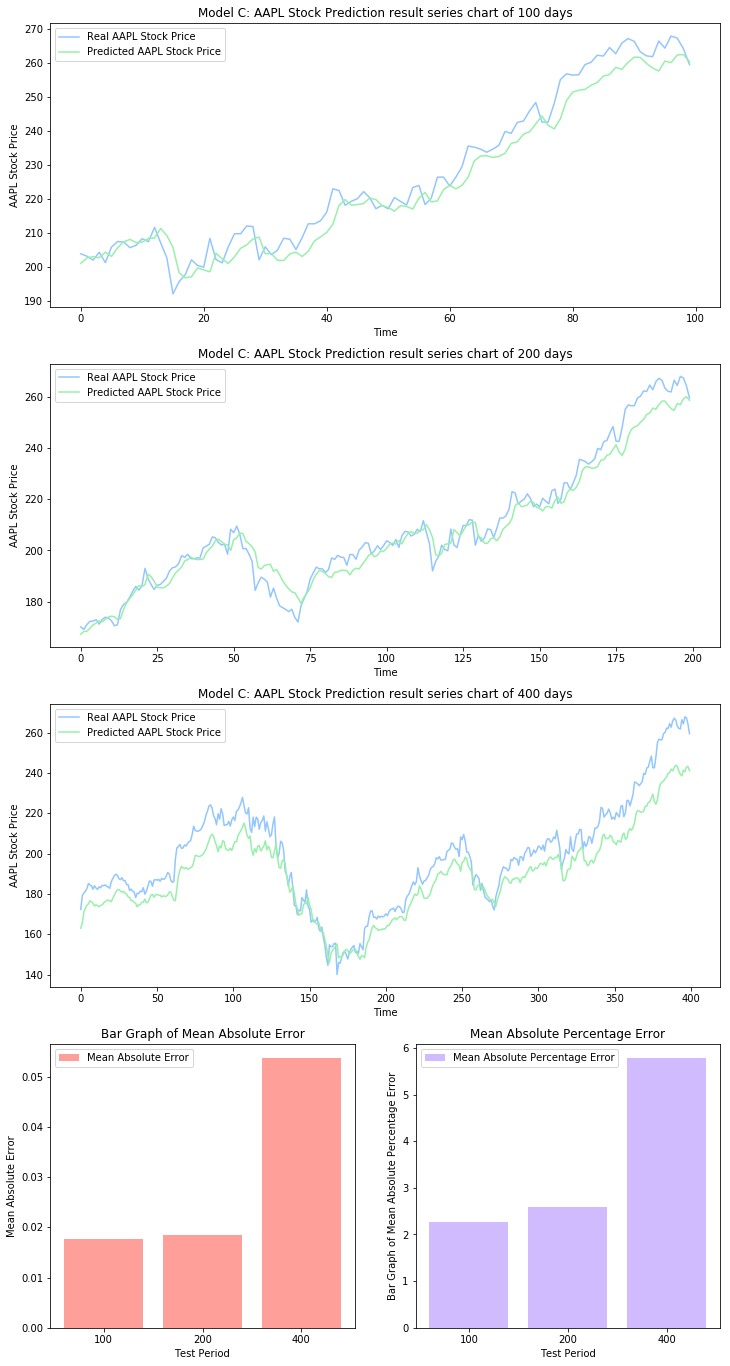

In [18]:
Test_period = [100, 200, 400]
ModelC =[]
for Peri in Test_period:
    C = LSTM_Predict_Model(aapl_data, Peri, Win=30, Tec=True, Pca=True, Pca_indicator=False)
    ModelC.append(C)
Visulization(ModelC,Test_period,'C')

## Model D:
### Input in model D involves basic trading data with calculated tech_indicator, buy only tech_indicator will need PCA adjustment

Tech_indicator is generated.
For Test Period = 100
Epoch 1/10
4855/4855 [==============================] - 6s 1ms/step - loss: 0.0026 - mae: 0.0293 - mape: 20.3256A: 0s - loss: 0.0027 - mae: 0.0299 - mape: 20
Epoch 2/10
4855/4855 [==============================] - 5s 1ms/step - loss: 7.6153e-04 - mae: 0.0186 - mape: 13.2871
Epoch 3/10
4855/4855 [==============================] - 5s 1ms/step - loss: 7.3249e-04 - mae: 0.0181 - mape: 12.4509
Epoch 4/10
4855/4855 [==============================] - 5s 1ms/step - loss: 6.0238e-04 - mae: 0.0170 - mape: 12.2815
Epoch 5/10
4855/4855 [==============================] - 5s 1ms/step - loss: 5.6453e-04 - mae: 0.0164 - mape: 11.6991
Epoch 6/10
4855/4855 [==============================] - 5s 1ms/step - loss: 5.4330e-04 - mae: 0.0162 - mape: 11.6486
Epoch 7/10
4855/4855 [==============================] - 5s 1ms/step - loss: 5.9434e-04 - mae: 0.0170 - mape: 12.2682
Epoch 8/10
4855/4855 [==============================] - 5s 990us/step - loss: 5.4834e-04 

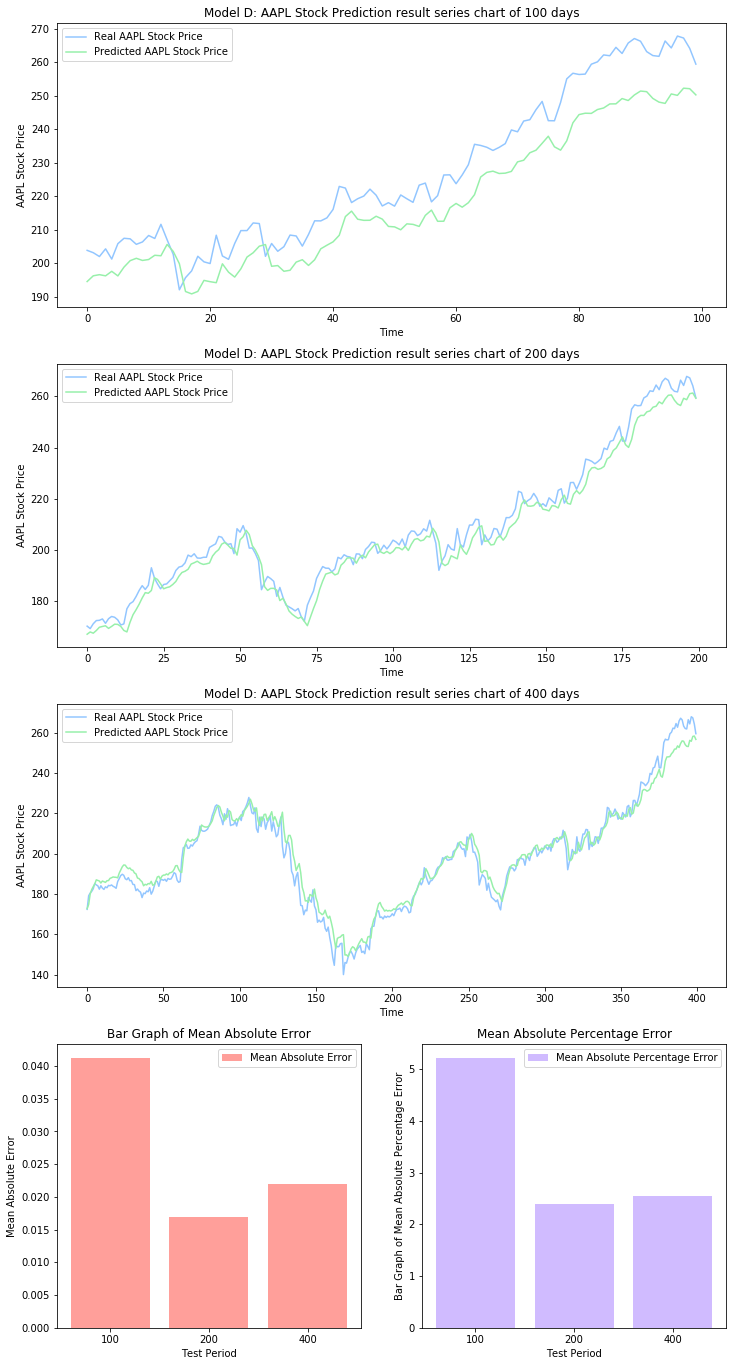

In [19]:
Test_period = [100, 200, 400]
ModelD =[]
for Peri in Test_period:
    D = LSTM_Predict_Model(aapl_data, Peri, Win=30, Tec=True, Pca=True, Pca_indicator=True)
    ModelD.append(D)
Visulization(ModelD,Test_period,'D')

## Comparison between the Model
### Here we select Test Period to be 100 days

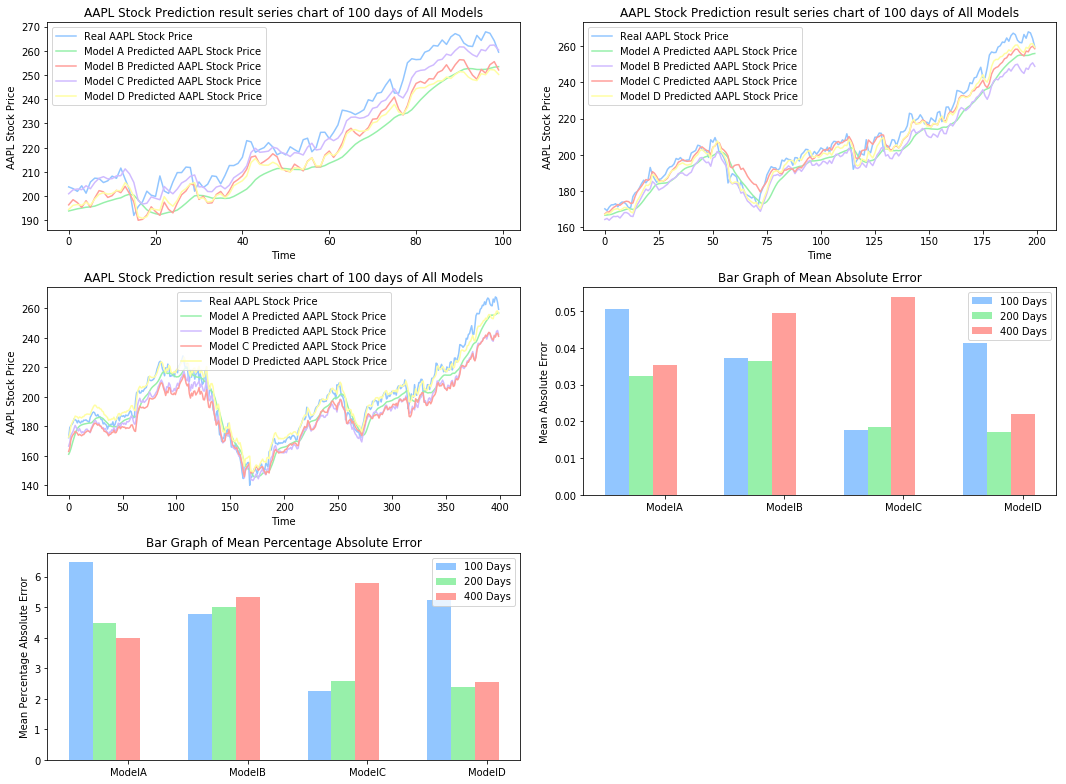

In [20]:
import seaborn as sns
c1, c2, c3,c4,c5 = sns.color_palette("pastel", 5)

fig1 = plt.figure(figsize=[15,11])
## 100 Days
ax1 = fig1.add_subplot(321)
ax1.plot(ModelA[0][0][0], color = c1, label = 'Real AAPL Stock Price')
ax1.plot(ModelA[0][0][1], color = c2, label = 'Model A Predicted AAPL Stock Price')
ax1.plot(ModelB[0][0][1], color = c3, label = 'Model B Predicted AAPL Stock Price')
ax1.plot(ModelC[0][0][1], color = c4, label = 'Model C Predicted AAPL Stock Price')
ax1.plot(ModelD[0][0][1], color = c5, label = 'Model D Predicted AAPL Stock Price')
ax1.set_title('AAPL Stock Prediction result series chart of 100 days of All Models')
ax1.set_xlabel('Time')
ax1.set_ylabel('AAPL Stock Price')
ax1.legend()

## 200 Days
ax2 = fig1.add_subplot(322)
ax2.plot(ModelA[1][0][0], color = c1, label = 'Real AAPL Stock Price')
ax2.plot(ModelA[1][0][1], color = c2, label = 'Model A Predicted AAPL Stock Price')
ax2.plot(ModelB[1][0][1], color = c4, label = 'Model B Predicted AAPL Stock Price')
ax2.plot(ModelC[1][0][1], color = c3, label = 'Model C Predicted AAPL Stock Price')
ax2.plot(ModelD[1][0][1], color = c5, label = 'Model D Predicted AAPL Stock Price')
ax2.set_title('AAPL Stock Prediction result series chart of 100 days of All Models')
ax2.set_xlabel('Time')
ax2.set_ylabel('AAPL Stock Price')
ax2.legend()

## 400 Days
ax3 = fig1.add_subplot(323)
ax3.plot(ModelA[2][0][0], color = c1, label = 'Real AAPL Stock Price')
ax3.plot(ModelA[2][0][1], color = c2, label = 'Model A Predicted AAPL Stock Price')
ax3.plot(ModelB[2][0][1], color = c4, label = 'Model B Predicted AAPL Stock Price')
ax3.plot(ModelC[2][0][1], color = c3, label = 'Model C Predicted AAPL Stock Price')
ax3.plot(ModelD[2][0][1], color = c5, label = 'Model D Predicted AAPL Stock Price')
ax3.set_title('AAPL Stock Prediction result series chart of 100 days of All Models')
ax3.set_xlabel('Time')
ax3.set_ylabel('AAPL Stock Price')
ax3.legend()

## MAE 
MAE_100D_Group=[ModelA[0][1][1],ModelB[0][1][1],ModelC[0][1][1],ModelD[0][1][1]]
MAE_200D_Group=[ModelA[1][1][1],ModelB[1][1][1],ModelC[1][1][1],ModelD[1][1][1]]
MAE_400D_Group=[ModelA[2][1][1],ModelB[2][1][1],ModelC[2][1][1],ModelD[2][1][1]]


ax4 = fig1.add_subplot(324)

ind = np.arange(len(MAE_100D_Group)) 

width = 0.2  

rect100D = ax4.bar(ind - width*2, MAE_100D_Group, width,color = c1,
                label='100 Days')
rect200D = ax4.bar(ind - width, MAE_200D_Group, width,color = c2,
                label='200 Days')
rect400D = ax4.bar(ind, MAE_400D_Group, width,color = c3,
                label='400 Days')


ax4.set_ylabel('Mean Absolute Error')
ax4.set_title('Bar Graph of Mean Absolute Error')
ax4.set_xticks(ind)
ax4.set_xticklabels(('ModelA', 'ModelB', 'ModelC','ModelD'))
ax4.legend()

##MAPE

MAPE_100D_Group=[ModelA[0][1][2],ModelB[0][1][2],ModelC[0][1][2],ModelD[0][1][2]]
MAPE_200D_Group=[ModelA[1][1][2],ModelB[1][1][2],ModelC[1][1][2],ModelD[1][1][2]]
MAPE_400D_Group=[ModelA[2][1][2],ModelB[2][1][2],ModelC[2][1][2],ModelD[2][1][2]]

ax5 = fig1.add_subplot(325)

ind = np.arange(len(MAPE_100D_Group)) 

width = 0.2  

rect100D = ax5.bar(ind - width*2, MAPE_100D_Group, width,color = c1,
                label='100 Days')
rect200D = ax5.bar(ind - width, MAPE_200D_Group, width,color = c2,
                label='200 Days')
rect400D = ax5.bar(ind, MAPE_400D_Group, width,color = c3,
                label='400 Days')


ax5.set_ylabel('Mean Percentage Absolute Error')
ax5.set_title('Bar Graph of Mean Percentage Absolute Error')
ax5.set_xticks(ind)
ax5.set_xticklabels(('ModelA', 'ModelB', 'ModelC','ModelD'))
ax5.legend()

fig1.tight_layout()
plt.show()

In [21]:
print(MAE_100D_Group)
print(MAE_200D_Group)
print(MAE_400D_Group)


[0.05065916106104851, 0.037372685968875885, 0.01766420528292656, 0.041277311742305756]
[0.03234246373176575, 0.03641882166266441, 0.01845419593155384, 0.017006395384669304]
[0.035276468843221664, 0.04938996210694313, 0.0537882037460804, 0.021979231387376785]


In [22]:
print(MAPE_100D_Group)
print(MAPE_200D_Group)
print(MAPE_400D_Group)


[6.467175483703613, 4.78187370300293, 2.2678654193878174, 5.224923133850098]
[4.479041576385498, 5.002045631408691, 2.5833559036254883, 2.4008054733276367]
[3.9816596508026123, 5.340299129486084, 5.789116382598877, 2.5526976585388184]


## After comparison between Model A,B,C,D. We found that the Model results varies, because of the weight initialization process within the LSTM model.
## So we think of using Monte Carlo Method, which just repeat each model, then to get the average performance of each Model.

## Monte Carlo

In [23]:
## Run 4 model 10 times:
Run_times = 10

Test_period = [100, 200, 400]

## To Store the Metrics for each time

ModelA_list =[]
ModelB_list =[]
ModelC_list =[]
ModelD_list =[]

for i in range(Run_times):
    for Peri in Test_period:
        A = LSTM_Predict_Model(aapl_data, Peri, 30, Tech_indicator, PCA_use, PCA_only_indicator)
        ModelA_list.append(A[1])
        B = LSTM_Predict_Model(aapl_data, Peri, Win=30, Tec=True, Pca=False, Pca_indicator=False)
        ModelB_list.append(B[1])
        C = LSTM_Predict_Model(aapl_data, Peri, Win=30, Tec=True, Pca=True, Pca_indicator=False)
        ModelC_list.append(C[1])
        D = LSTM_Predict_Model(aapl_data, Peri, Win=30, Tec=True, Pca=True, Pca_indicator=True)
        ModelD_list.append(D[1])
    print("\n------"+str(i+1)+"iterations has done-------\n")

## Model A
ModelA_100_MAE_Mean=np.mean([ModelA_list[i][1] for i in range(0,len(ModelA_list),len(Test_period))])
ModelA_100_MAPE_Mean=np.mean([ModelA_list[i][2] for i in range(0,len(ModelA_list),len(Test_period))])

ModelA_200_MAE_Mean=np.mean([ModelA_list[i][1] for i in range(1,len(ModelA_list),len(Test_period))])
ModelA_200_MAPE_Mean=np.mean([ModelA_list[i][2] for i in range(1,len(ModelA_list),len(Test_period))])

ModelA_400_MAE_Mean=np.mean([ModelA_list[i][1] for i in range(2,len(ModelA_list),len(Test_period))])
ModelA_400_MAPE_Mean=np.mean([ModelA_list[i][2] for i in range(2,len(ModelA_list),len(Test_period))]) 

## Model B
ModelB_100_MAE_Mean=np.mean([ModelB_list[i][1] for i in range(0,len(ModelB_list),len(Test_period))])
ModelB_100_MAPE_Mean=np.mean([ModelB_list[i][2] for i in range(0,len(ModelB_list),len(Test_period))])

ModelB_200_MAE_Mean=np.mean([ModelB_list[i][1] for i in range(1,len(ModelB_list),len(Test_period))])
ModelB_200_MAPE_Mean=np.mean([ModelB_list[i][2] for i in range(1,len(ModelB_list),len(Test_period))])

ModelB_400_MAE_Mean=np.mean([ModelB_list[i][1] for i in range(2,len(ModelB_list),len(Test_period))])
ModelB_400_MAPE_Mean=np.mean([ModelB_list[i][2] for i in range(2,len(ModelB_list),len(Test_period))])

##Model C
ModelC_100_MAE_Mean=np.mean([ModelC_list[i][1] for i in range(0,len(ModelC_list),len(Test_period))])
ModelC_100_MAPE_Mean=np.mean([ModelC_list[i][2] for i in range(0,len(ModelC_list),len(Test_period))])

ModelC_200_MAE_Mean=np.mean([ModelC_list[i][1] for i in range(1,len(ModelC_list),len(Test_period))])
ModelC_200_MAPE_Mean=np.mean([ModelC_list[i][2] for i in range(1,len(ModelC_list),len(Test_period))])

ModelC_400_MAE_Mean=np.mean([ModelC_list[i][1] for i in range(2,len(ModelC_list),len(Test_period))])
ModelC_400_MAPE_Mean=np.mean([ModelC_list[i][2] for i in range(2,len(ModelC_list),len(Test_period))])

##Model D
ModelD_100_MAE_Mean=np.mean([ModelD_list[i][1] for i in range(0,len(ModelD_list),len(Test_period))])
ModelD_100_MAPE_Mean=np.mean([ModelD_list[i][2] for i in range(0,len(ModelD_list),len(Test_period))])

ModelD_200_MAE_Mean=np.mean([ModelD_list[i][1] for i in range(1,len(ModelD_list),len(Test_period))])
ModelD_200_MAPE_Mean=np.mean([ModelD_list[i][2] for i in range(1,len(ModelD_list),len(Test_period))])

ModelD_400_MAE_Mean=np.mean([ModelD_list[i][1] for i in range(2,len(ModelD_list),len(Test_period))])
ModelD_400_MAPE_Mean=np.mean([ModelD_list[i][2] for i in range(2,len(ModelD_list),len(Test_period))])


## Summarize the MEAN of MAE and MAPE


MAE_100D_Group_Mean=[ModelA_100_MAE_Mean,ModelB_100_MAE_Mean,ModelC_100_MAE_Mean,ModelD_100_MAE_Mean]
MAE_200D_Group_Mean=[ModelA_200_MAE_Mean,ModelB_200_MAE_Mean,ModelC_200_MAE_Mean,ModelD_200_MAE_Mean]
MAE_400D_Group_Mean=[ModelA_400_MAE_Mean,ModelB_400_MAE_Mean,ModelC_400_MAE_Mean,ModelD_400_MAE_Mean]


MAPE_100D_Group_Mean=[ModelA_100_MAPE_Mean,ModelB_100_MAPE_Mean,ModelC_100_MAPE_Mean,ModelD_100_MAPE_Mean]
MAPE_200D_Group_Mean=[ModelA_200_MAPE_Mean,ModelB_200_MAPE_Mean,ModelC_200_MAPE_Mean,ModelD_200_MAPE_Mean]
MAPE_400D_Group_Mean=[ModelA_400_MAPE_Mean,ModelB_400_MAPE_Mean,ModelC_400_MAPE_Mean,ModelD_400_MAPE_Mean]


For Test Period = 100
Epoch 1/10
4882/4882 [==============================] - 6s 1ms/step - loss: 0.0019 - mae: 0.0266 - mape: 21.3511
Epoch 2/10
4882/4882 [==============================] - 5s 974us/step - loss: 8.1368e-04 - mae: 0.0192 - mape: 15.1829
Epoch 3/10
4882/4882 [==============================] - 5s 974us/step - loss: 7.5423e-04 - mae: 0.0182 - mape: 14.4630
Epoch 4/10
4882/4882 [==============================] - 5s 972us/step - loss: 7.0308e-04 - mae: 0.0179 - mape: 14.9529
Epoch 5/10
4882/4882 [==============================] - 5s 967us/step - loss: 6.6493e-04 - mae: 0.0175 - mape: 14.0899
Epoch 6/10
4882/4882 [==============================] - 5s 973us/step - loss: 7.1665e-04 - mae: 0.0186 - mape: 17.1785
Epoch 7/10
4882/4882 [==============================] - 5s 974us/step - loss: 6.3934e-04 - mae: 0.0173 - mape: 14.6510
Epoch 8/10
4882/4882 [==============================] - 5s 972us/step - loss: 6.0750e-04 - mae: 0.0170 - mape: 14.9013
Epoch 9/10
4882/4882 [==========

4555/4555 [==============================] - 4s 975us/step - loss: 6.0181e-04 - mae: 0.0172 - mape: 15.8957
Epoch 6/10
4555/4555 [==============================] - 4s 965us/step - loss: 8.2367e-04 - mae: 0.0201 - mape: 19.1818
Epoch 7/10
4555/4555 [==============================] - 4s 966us/step - loss: 6.6469e-04 - mae: 0.0176 - mape: 16.4557
Epoch 8/10
4555/4555 [==============================] - 5s 1ms/step - loss: 6.7033e-04 - mae: 0.0180 - mape: 15.2925
Epoch 9/10
4555/4555 [==============================] - 4s 964us/step - loss: 6.0474e-04 - mae: 0.0171 - mape: 16.7558
Epoch 10/10
400/400 [==============================] - 0s 598us/step

-----Model Evaluation Result of 400 Days Testing Period-----

Loss value: 0.0014729428431019187
MAE: 0.030472595244646072
MAPE: 3.3445823192596436



------1iterations has done-------

For Test Period = 100
Epoch 1/10
4882/4882 [==============================] - 6s 1ms/step - loss: 0.0021 - mae: 0.0266 - mape: 19.8470
Epoch 2/10
4882/4882 [======

4755/4755 [==============================] - 6s 1ms/step - loss: 0.0029 - mae: 0.0306 - mape: 42.3534
Epoch 2/10
4755/4755 [==============================] - 5s 1ms/step - loss: 7.3121e-04 - mae: 0.0190 - mape: 40.8563
Epoch 3/10
4755/4755 [==============================] - 5s 1ms/step - loss: 6.5706e-04 - mae: 0.0177 - mape: 47.2443
Epoch 4/10
4755/4755 [==============================] - 5s 1ms/step - loss: 6.3895e-04 - mae: 0.0175 - mape: 34.5447
Epoch 5/10
4755/4755 [==============================] - 5s 1ms/step - loss: 5.8941e-04 - mae: 0.0166 - mape: 19.1599
Epoch 6/10
4755/4755 [==============================] - 5s 1ms/step - loss: 5.5630e-04 - mae: 0.0164 - mape: 27.5646
Epoch 7/10
4755/4755 [==============================] - 5s 1ms/step - loss: 5.1947e-04 - mae: 0.0160 - mape: 37.6017
Epoch 8/10
4755/4755 [==============================] - 5s 1ms/step - loss: 5.5481e-04 - mae: 0.0164 - mape: 27.6157
Epoch 9/10
4755/4755 [==============================] - 5s 1ms/step - loss: 4.8

D:\Coding\Anaconda\Lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100261). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


4755/4755 [==============================] - 20s 4ms/step - loss: 0.0027 - mae: 0.0291 - mape: 39.1379
Epoch 2/10
4755/4755 [==============================] - 5s 1ms/step - loss: 7.1382e-04 - mae: 0.0182 - mape: 40.8270
Epoch 3/10
4755/4755 [==============================] - 5s 1ms/step - loss: 6.4196e-04 - mae: 0.0172 - mape: 31.2187
Epoch 4/10
4755/4755 [==============================] - 5s 1ms/step - loss: 5.6464e-04 - mae: 0.0164 - mape: 22.0499
Epoch 5/10
4755/4755 [==============================] - 5s 1ms/step - loss: 5.7543e-04 - mae: 0.0162 - mape: 33.5442A: 1s - loss: 5.7522e-04 - ma
Epoch 6/10
4755/4755 [==============================] - 5s 1ms/step - loss: 5.6095e-04 - mae: 0.0159 - mape: 32.4986
Epoch 7/10
4755/4755 [==============================] - 5s 1ms/step - loss: 5.5929e-04 - mae: 0.0162 - mape: 29.7382
Epoch 8/10
4755/4755 [==============================] - 5s 1ms/step - loss: 4.5868e-04 - mae: 0.0150 - mape: 20.9504A
Epoch 9/10
4755/4755 [==========================

4755/4755 [==============================] - 7s 1ms/step - loss: 0.0055 - mae: 0.0410 - mape: 184.4063
Epoch 2/10
4755/4755 [==============================] - 6s 1ms/step - loss: 7.8671e-04 - mae: 0.0195 - mape: 45.6039
Epoch 3/10
4755/4755 [==============================] - 6s 1ms/step - loss: 6.5701e-04 - mae: 0.0179 - mape: 57.8977
Epoch 4/10
4755/4755 [==============================] - 6s 1ms/step - loss: 6.5426e-04 - mae: 0.0176 - mape: 40.9360
Epoch 5/10
4755/4755 [==============================] - 6s 1ms/step - loss: 6.2241e-04 - mae: 0.0173 - mape: 37.8497
Epoch 6/10
4755/4755 [==============================] - 6s 1ms/step - loss: 5.4386e-04 - mae: 0.0162 - mape: 50.9838
Epoch 7/10
4755/4755 [==============================] - 6s 1ms/step - loss: 6.2712e-04 - mae: 0.0173 - mape: 54.9460
Epoch 8/10
4755/4755 [==============================] - 6s 1ms/step - loss: 4.8246e-04 - mae: 0.0153 - mape: 32.8783
Epoch 9/10
4755/4755 [==============================] - 6s 1ms/step - loss: 6.

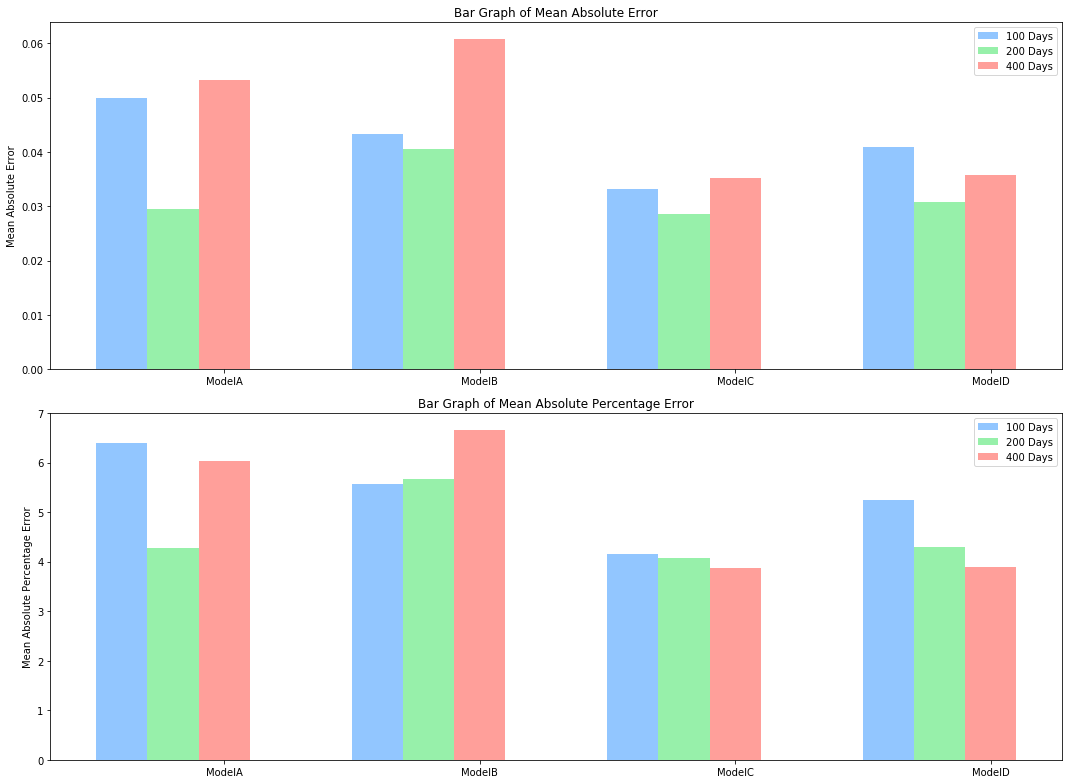

In [24]:
## Plot the bar of MAE & MAPE

import seaborn as sns
c1, c2, c3 = sns.color_palette("pastel", 3)

fig2 = plt.figure(figsize=[15,11])

ax1 = fig2.add_subplot(211)

ind = np.arange(len(MAE_100D_Group_Mean)) 

width = 0.2  

rect100D = ax1.bar(ind - width*2, MAE_100D_Group_Mean, width,color=c1,
                label='100 Days')
rect200D = ax1.bar(ind - width, MAE_200D_Group_Mean, width,color=c2,
                label='200 Days')
rect400D = ax1.bar(ind, MAE_400D_Group_Mean, width,color=c3,
                label='400 Days')


ax1.set_ylabel('Mean Absolute Error')
ax1.set_title('Bar Graph of Mean Absolute Error')
ax1.set_xticks(ind)
ax1.set_xticklabels(('ModelA', 'ModelB', 'ModelC','ModelD'))
ax1.legend()

ax2 = fig2.add_subplot(212)

ind = np.arange(len(MAE_100D_Group_Mean)) 

width = 0.2  

rect100D = ax2.bar(ind - width*2, MAPE_100D_Group_Mean, width,color=c1,
                label='100 Days')
rect200D = ax2.bar(ind - width, MAPE_200D_Group_Mean, width,color=c2,
                label='200 Days')
rect400D = ax2.bar(ind, MAPE_400D_Group_Mean, width,color=c3,
                label='400 Days')


ax2.set_ylabel('Mean Absolute Percentage Error')
ax2.set_title('Bar Graph of Mean Absolute Percentage Error')
ax2.set_xticks(ind)
ax2.set_xticklabels(('ModelA', 'ModelB', 'ModelC','ModelD'))
ax2.legend()

fig2.tight_layout()
plt.show()

## Conclusion:

## Because of the variety of the results, we choose Monte Carlo Method in order to get  average metrics of each model. Baesd on the result, we think Model C (Apply PCA to all features) and Model D(Apply PCA only to techical indicators) have better prediction ability.
## The next step is our own exploration and contribution based on our own idea, which is shown in the other notebook. In short:
## 1. We select Model D as our target model, and set the seed fixed so we can get fixed initial weights in LSTM. And then we try to find the optimal params for the LSTM model, given the test period of 100days. That includes units and batch_size, for epoch, we use Earlystopping to let it decide.
## 2. Use those params, we build up our model. In order to test what we do with it, we set up several Trading strategy based on the prediction.
## 3. Apart from the technical indicators, we add in Fama-French 5 factors, to see whether it improved the prediction. Also we tried used this specific model to predict S&P500 index to check whether it can be generalized.